#### Importing necessary libraries

In [512]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split


#### Reading br_payroll.tsv into a Dataframe

In [513]:
payroll_data = pd.read_csv('~/payroll-prediction/data/payroll_sample_tables_for_Teradata-master/br_payroll.tsv',sep='\t',header=None)
payroll_data.columns = [
    "employee_number",
    "last_name",
    "first_name",
    "middle_initial",
    "name_suffix",
    "birthdate",
    "department_number",
    "division_number",
    "job_code",
    "pay_grade",
    "pay_step",
    "gender",
    "race",
    "hire_date",
    "hire_end_date",
    "years_of_service",
    "scheduled_hours",
    "longevity_percentage",
    "base_hourly_rate",
    "total_hourly_rate",
    "overtime_hourly_rate",
    "annual_salary",
    "status"
]
print(payroll_data.head(5))
print(payroll_data.shape)

# Clean the data by removing rows with missing or zero annual salary
payroll_data = payroll_data[payroll_data['annual_salary'] > 0]

   employee_number last_name first_name middle_initial name_suffix  \
0               78     Achee      Murel              J         NaN   
1               86    Achord      Brice              B         NaN   
2               94    Achord     Robert              J         NaN   
3              124     Achee    Winston              A         NaN   
4              132     Adams      Leola            NaN         NaN   

    birthdate  department_number  division_number  job_code  pay_grade  ...  \
0  1938-05-10                 70          7003000  101220.0      117.0  ...   
1  1948-01-26                 52          5230001       NaN      305.0  ...   
2  1967-06-11                 21          2110000  182119.0     1200.0  ...   
3  1950-03-25                 50          5020001    5020.0     2116.0  ...   
4  1943-11-10                 50          5020001  105470.0      100.0  ...   

    hire_date hire_end_date years_of_service scheduled_hours  \
0  1960-07-19    1990-09-29             

##### Dropping columns that are not required for the building the model ('employee_number', 'last_name', 'first_name', 'middle_initial', 'name_suffix','gender', 'race','birthdate','hire_date', 'hire_end_date', 'status')

In [514]:
payroll_data = payroll_data.drop(columns=['employee_number', 'last_name', 'first_name', 'middle_initial', 'name_suffix','gender', 'race','birthdate','hire_date', 'hire_end_date', 'status'])

print(payroll_data.shape)
print(payroll_data.info())

(20556, 12)
<class 'pandas.core.frame.DataFrame'>
Index: 20556 entries, 0 to 24739
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   department_number     20556 non-null  int64  
 1   division_number       20556 non-null  int64  
 2   job_code              18882 non-null  float64
 3   pay_grade             17089 non-null  float64
 4   pay_step              17089 non-null  float64
 5   years_of_service      20556 non-null  int64  
 6   scheduled_hours       20556 non-null  float64
 7   longevity_percentage  20556 non-null  float64
 8   base_hourly_rate      20556 non-null  float64
 9   total_hourly_rate     20556 non-null  float64
 10  overtime_hourly_rate  20556 non-null  float64
 11  annual_salary         20556 non-null  float64
dtypes: float64(9), int64(3)
memory usage: 2.0 MB
None


#### Reading br_jobs.tsv into a Dataframe

In [515]:
jobs_data = pd.read_csv('~/payroll-prediction/data/payroll_sample_tables_for_Teradata-master/br_jobs.tsv',sep='\t',header=None)
jobs_data.columns = [
    "job_code",
    "pay_grade",
    "legacy_flag",
    "job_title"
]
#jobs_data = jobs_data[jobs_data['legacy_flag']==0]
print(jobs_data.shape)


(1226, 4)


#### Reading br_departments.tsv into a Dataframe

In [516]:
departments_data = pd.read_csv('~/payroll-prediction/data/payroll_sample_tables_for_Teradata-master/br_departments.tsv',sep='\t',header=None)
departments_data.columns = [
    "department_number",
    "acronym",
    "department_name",
    "budget_amount",
    "manager_employee_number"
]
print(departments_data.shape)
print(departments_data['department_name'].unique)

(53, 5)
<bound method Series.unique of 0                                  Metropolitan Council
1                                 Council Administrator
2                                 Council Budget Office
3                                       Parish Attorney
4                             Public Information Office
5                        Animal Control & Rescue Center
6                           Greater BR Airport District
7                             Fire Protection Districts
8        Mosquito Abatement and Rodent Control District
9                              Library Board of Control
10                        Downtown Development District
11                                  Planning Commission
12                          EBR Redevelopment Authority
13                                           City Court
14                                       City Constable
15                  Justice of Peace and Ward Constable
16                                       District Court
17       

#### Reading br_divisions.tsv into a Dataframe

In [517]:
divisions_data = pd.read_csv('~/payroll-prediction/data/payroll_sample_tables_for_Teradata-master/br_divisions.tsv',sep='\t',header=None)
divisions_data.columns = [
    "department_number",
    "division_number",
    "division_name"
]
print(divisions_data.shape)

print(divisions_data['division_name'].unique)

(271, 3)
<bound method Series.unique of 0                                         MC-District  2
1      MC-Community Centers-Dr. Martin Luther King, J...
2                                         MC-District 12
3                                         MC-District  5
4                                         MC-District  7
                             ...                        
266    Buildings and Grounds-Public Building Maintenance
267         Buildings and Grounds-Architectural Services
268                 Buildings and Grounds-Administration
269    Fleet Management-Central Garage Operations & M...
270                                 Unidentified Charges
Name: division_name, Length: 271, dtype: object>


#### Reading br_pay_plan.tsv into a Dataframe

In [518]:
pay_plan_data = pd.read_csv('~/payroll-prediction/data/payroll_sample_tables_for_Teradata-master/br_pay_plan.tsv',sep='\t',header=None)
pay_plan_data.columns = [
    "pay_grade",
    "pay_step",
    "annual_salary"
]
print(pay_plan_data.shape)
print(min(pay_plan_data['pay_grade']), max(pay_plan_data['pay_grade']))
print(pay_plan_data['pay_grade'].unique())
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(pay_plan_data[['pay_grade','pay_step','annual_salary']].nunique)

(2479, 3)
1010 9999
[1010 1040 1050 1056 1057 1060 1070 1076 1080 1081 1086 1090 1091 1096
 1100 1101 1110 1111 1120 1121 1125 1130 1131 1140 1141 1145 1150 1151
 1155 1160 1161 1165 1170 1171 1175 1180 1181 1190 1191 1200 1201 1210
 1211 1231 1251 2070 2080 2090 2100 2110 2120 2130 2136 2140 2146 2150
 2160 2170 2180 2190 2200 2201 2205 2210 2211 2220 2221 2230 2231 2240
 2241 2250 2251 2260 2270 2280 2290 2295 2300 2310 2320 2330 2335 2340
 2350 2360 2370 2380 3010 3020 3040 3050 3060 3070 3080 3090 3100 3101
 3110 3120 3121 3130 3131 3140 3150 3160 3170 3175 3180 3200 7014 7019
 7020 7035 7060 7065 7080 7085 7090 7095 7120 7125 7130 7201 7210 7220
 7235 7260 8021 8026 8261 8331 8332 9999]
<bound method DataFrame.nunique of       pay_grade  pay_step  annual_salary
0          1010         1        15080.0
1          1040        10        22354.0
2          1040        11        23009.0
3          1040        12        23685.0
4          1040        13        24381.0
5          1040   

In [519]:
merged_job = pd.merge(payroll_data, jobs_data, on='job_code', how='left')
merged_dept = pd.merge(merged_job, departments_data, on='department_number', how='left')
merged_div = pd.merge(merged_dept, divisions_data, on='division_number', how='left')

print(merged_div.columns)

merged_df = merged_div.drop(columns=['department_number_x', 'department_number_y','division_number', 'job_code', 'pay_grade_y','legacy_flag','acronym','manager_employee_number','manager_employee_number','budget_amount','division_name']).rename(columns={'pay_grade_x': 'pay_grade'})

#merged_df = pd.merge(merged_df1, pay_plan_data, on=['pay_grade', 'pay_step'], how='inner')


print("Merged DataFrame Shape:")
print(merged_df.shape)
print(merged_df.columns)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(merged_df.head(5))

Index(['department_number_x', 'division_number', 'job_code', 'pay_grade_x',
       'pay_step', 'years_of_service', 'scheduled_hours',
       'longevity_percentage', 'base_hourly_rate', 'total_hourly_rate',
       'overtime_hourly_rate', 'annual_salary', 'pay_grade_y', 'legacy_flag',
       'job_title', 'acronym', 'department_name', 'budget_amount',
       'manager_employee_number', 'department_number_y', 'division_name'],
      dtype='object')
Merged DataFrame Shape:
(20556, 11)
Index(['pay_grade', 'pay_step', 'years_of_service', 'scheduled_hours',
       'longevity_percentage', 'base_hourly_rate', 'total_hourly_rate',
       'overtime_hourly_rate', 'annual_salary', 'job_title',
       'department_name'],
      dtype='object')
   pay_grade  pay_step  years_of_service  scheduled_hours  \
0      117.0       5.0                30             80.0   
1      305.0       9.0                26             80.0   
2     1200.0      12.0                21             80.0   
3     2116.0      1

##### Using only Job_titles that have atleast 200 records each

In [520]:
job_title_counts = merged_df['job_title'].value_counts()

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print("Job title counts:", job_title_counts[job_title_counts > 200])

Job title counts: job_title
College Student Intern/Contract    1895
Laborer                            1798
Police Officer                      829
Library Page (20 hrs)               630
School Crossing Guard               526
Library Technician I (10 hrs)       480
Maintenance Worker I                450
Firefighter                         441
Exception Job Code                  384
EMT Paramedic                       297
Library Technician I                295
Maintenance Worker II               268
Police Sergeant                     226
Fire Captain                        222
Police Captain                      221
Senior Clerical Specialist          215
Displaced Disaster Worker           213
Police Lieutenant                   209
Name: count, dtype: int64


In [521]:
# Keep only frequent job titles
frequent_titles = job_title_counts[job_title_counts > 200].index

merged_df_1 = merged_df[merged_df['job_title'].isin(frequent_titles)]
print(merged_df_1.shape)

(9599, 11)


#### Distribution of departments

In [522]:
department_name_counts = merged_df_1['department_name'].value_counts()


print("Job title counts:", department_name_counts)

Job title counts: department_name
Public Works                                                    2409
Police Department                                               2237
Library Board of Control                                        1411
Fire Department                                                  733
Emergency Medical Services                                       602
Human Development and Services                                   437
Maintenance                                                      305
Finance Department                                               272
City Court                                                       185
Parish Attorney                                                  149
Payroll History Validation                                       120
Planning Commission                                              111
Greater BR Airport District                                      109
Office of the Mayor-President                                     69


In [523]:
# Keep only frequent department_name_counts (NOT USED - TO REDUCE DIMENSIONALITY)
frequent_titles = department_name_counts.index

merged_df_2 = merged_df_1[merged_df_1['department_name'].isin(frequent_titles)]
print(merged_df_2.shape)

(9599, 11)


##### Missing value percentage

In [524]:
missing = merged_df_2.isnull().sum()
missing_percentage = (missing / payroll_data.shape[0]) * 100
print("Missing values in each column:")
print(missing_percentage)

Missing values in each column:
pay_grade               13.198093
pay_step                13.198093
years_of_service         0.000000
scheduled_hours          0.000000
longevity_percentage     0.000000
base_hourly_rate         0.000000
total_hourly_rate        0.000000
overtime_hourly_rate     0.000000
annual_salary            0.000000
job_title                0.000000
department_name          0.000000
dtype: float64


#### Distribution of Numeric fields

In [525]:
numeric_df = merged_df_2[["years_of_service",
    "scheduled_hours",
    "longevity_percentage",
    "base_hourly_rate",
    "total_hourly_rate",
    "overtime_hourly_rate",
    "pay_grade",
    "pay_step",
    "annual_salary"
]]
numeric_df.describe()

,years_of_service,scheduled_hours,longevity_percentage,base_hourly_rate,total_hourly_rate,overtime_hourly_rate,pay_grade,pay_step,annual_salary
count,9599.000000,9599.000000,9599.000000,9599.000000,9599.000000,9599.000000,6886.000000,6886.000000,9599.00000
mean,5.227003,69.875300,0.016961,11.392017,11.699791,18.184056,2460.240343,5.676881,21715.73736
std,8.650795,32.554578,0.052577,6.081954,6.514652,10.864318,2362.834531,5.683699,15251.63220
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,100.000000,1.000000,12.00000
25%,0.000000,58.000000,0.000000,7.250000,7.250000,10.880000,1040.000000,1.000000,11310.00000
50%,1.000000,80.000000,0.000000,9.000000,9.000000,13.500000,1150.000000,3.000000,16749.20000
75%,6.000000,80.000000,0.000000,13.770000,14.170000,21.930000,3150.000000,9.000000,29226.08000
max,44.000000,999.000000,0.200000,42.800000,42.800000,64.200000,8081.000000,21.000000,72012.20000


#### Checking count of records with Scheduled hours 999 and removing those records

In [526]:
print('Records were sceduled_hours is 999 hrs:',merged_df_2[merged_df_2['scheduled_hours'] == 999].shape[0])
merged_df_3 = merged_df_2[merged_df_2['scheduled_hours'] != 999]
numeric_df = merged_df_3[["years_of_service",
    "scheduled_hours",
    "longevity_percentage",
    "base_hourly_rate",
    "total_hourly_rate",
    "overtime_hourly_rate",
    "pay_grade",
    "pay_step",
    "annual_salary"
]]
numeric_df.describe()

Records were sceduled_hours is 999 hrs: 6


,years_of_service,scheduled_hours,longevity_percentage,base_hourly_rate,total_hourly_rate,overtime_hourly_rate,pay_grade,pay_step,annual_salary
count,9593.000000,9593.000000,9593.000000,9593.000000,9593.000000,9593.000000,6886.000000,6886.000000,9593.000000
mean,5.229542,69.294173,0.016972,11.399142,11.707107,18.195425,2460.240343,5.676881,21729.312094
std,8.652803,22.806365,0.052591,6.077177,6.510114,10.858196,2362.834531,5.683699,15246.735757
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,100.000000,1.000000,12.000000
25%,0.000000,58.000000,0.000000,7.250000,7.250000,10.880000,1040.000000,1.000000,11310.000000
50%,1.000000,80.000000,0.000000,9.000000,9.000000,13.500000,1150.000000,3.000000,16749.200000
75%,6.000000,80.000000,0.000000,13.770000,14.170000,21.930000,3150.000000,9.000000,29226.080000
max,44.000000,121.000000,0.200000,42.800000,42.800000,64.200000,8081.000000,21.000000,72012.200000


#### Understanding how many records with scheduled hours as 0

In [527]:
print('Records were sceduled_hours is 0 hrs:',merged_df_3[merged_df_3['scheduled_hours'] == 0].shape[0])

Records were sceduled_hours is 0 hrs: 95


#### Correlation Matrix

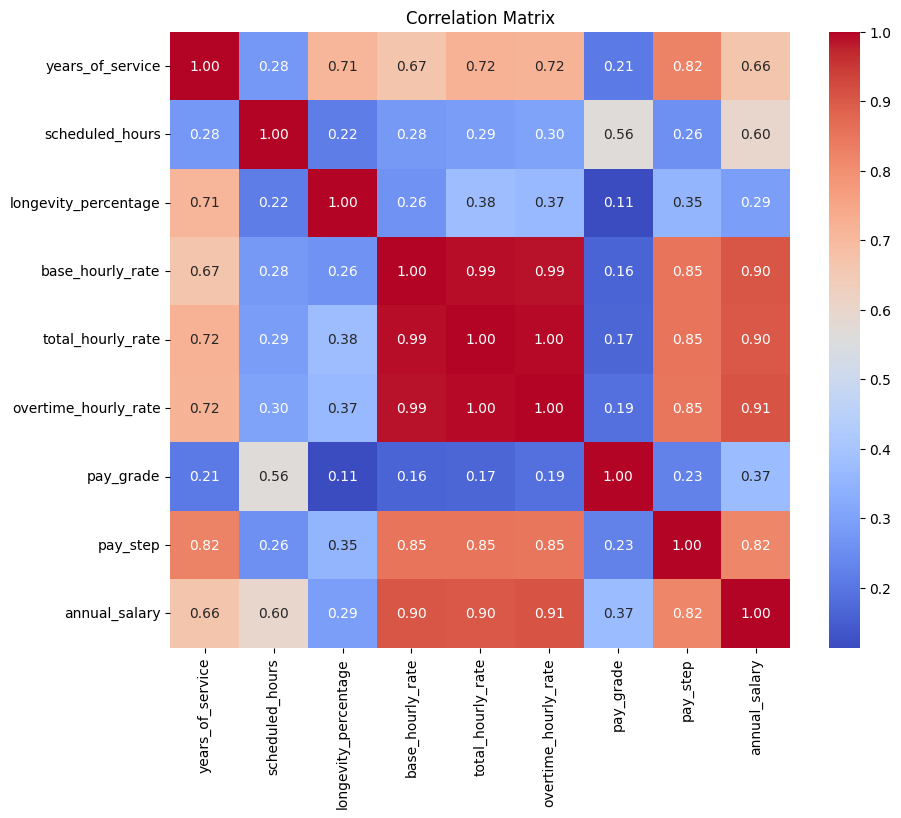

In [528]:
import seaborn as sns
import matplotlib.pyplot as plt

# Only keep continuous variables
numeric_df = merged_df_3[["years_of_service",
    "scheduled_hours",
    "longevity_percentage",
    "base_hourly_rate",
    "total_hourly_rate",
    "overtime_hourly_rate",
    "pay_grade",
    "pay_step",
    "annual_salary"
]]

# Plot pairplot
# sns.pairplot(numeric_df)
# plt.show()

corr = numeric_df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()


#### Key Insights
1. base_hourly_raye, total_hourly_rate and overtime_hourly_rate, pay_step has a high correlation with annual_salary (>0.8) <br> 
2. years_of_schedule, scheduled_hours has a moderate correlation with annual_salary (>0.5) <br>
3. years_of_service highly correlated with - longevity_percentage,total_hourly_rate, overtime_hourly_rate and pay_step <br>
4. base_hourly_rate, total_hourly_rate and overtime_hourly_rate,pay_step are highly correlated with each other. <br>


#### Overtime_ratio
Why it was created:

1. To capture the relative premium an employee earns for working overtime.

2. A higher ratio may signal roles with frequent or costly overtime — potential drivers of total compensation that base rate alone cannot explain.

3. It helps normalize differences across job titles, as some roles may have high overtime rates despite modest base pay.

Value to the model:

1. Adds granularity beyond absolute pay values.

2. Can highlight anomalies or outliers, such as roles with unusually high overtime premiums.

3. May improve predictive performance and model interpretability, especially when detecting compensation inconsistencies.



/var/folders/70/bv9d2gzn4373dn9w5fts5_f40000gp/T/ipykernel_7307/870778350.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df_3["overtime_ratio"] = np.where(


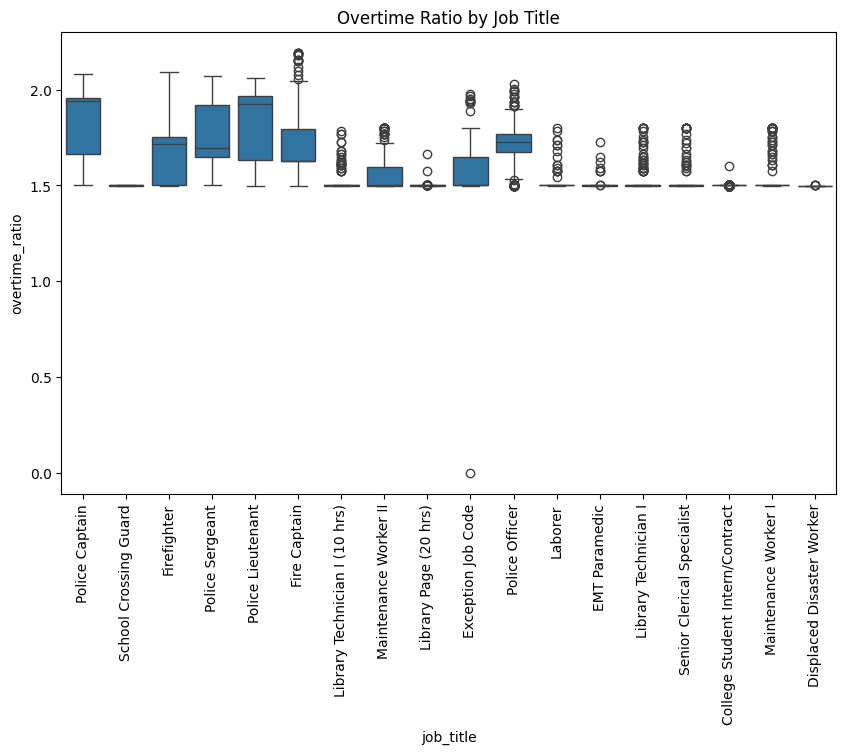

In [529]:
merged_df_3["overtime_ratio"] = np.where(
    merged_df_3['base_hourly_rate'] != 0,
    merged_df_3['overtime_hourly_rate'] / merged_df_3['base_hourly_rate'],
    0
)

# Check the distribution of overtime_ratio by job_titles
plt.figure(figsize=(10, 6))
sns.boxplot(x='job_title', y='overtime_ratio', data=merged_df_3)
plt.xticks(rotation=90)
plt.title("Overtime Ratio by Job Title")
plt.show()


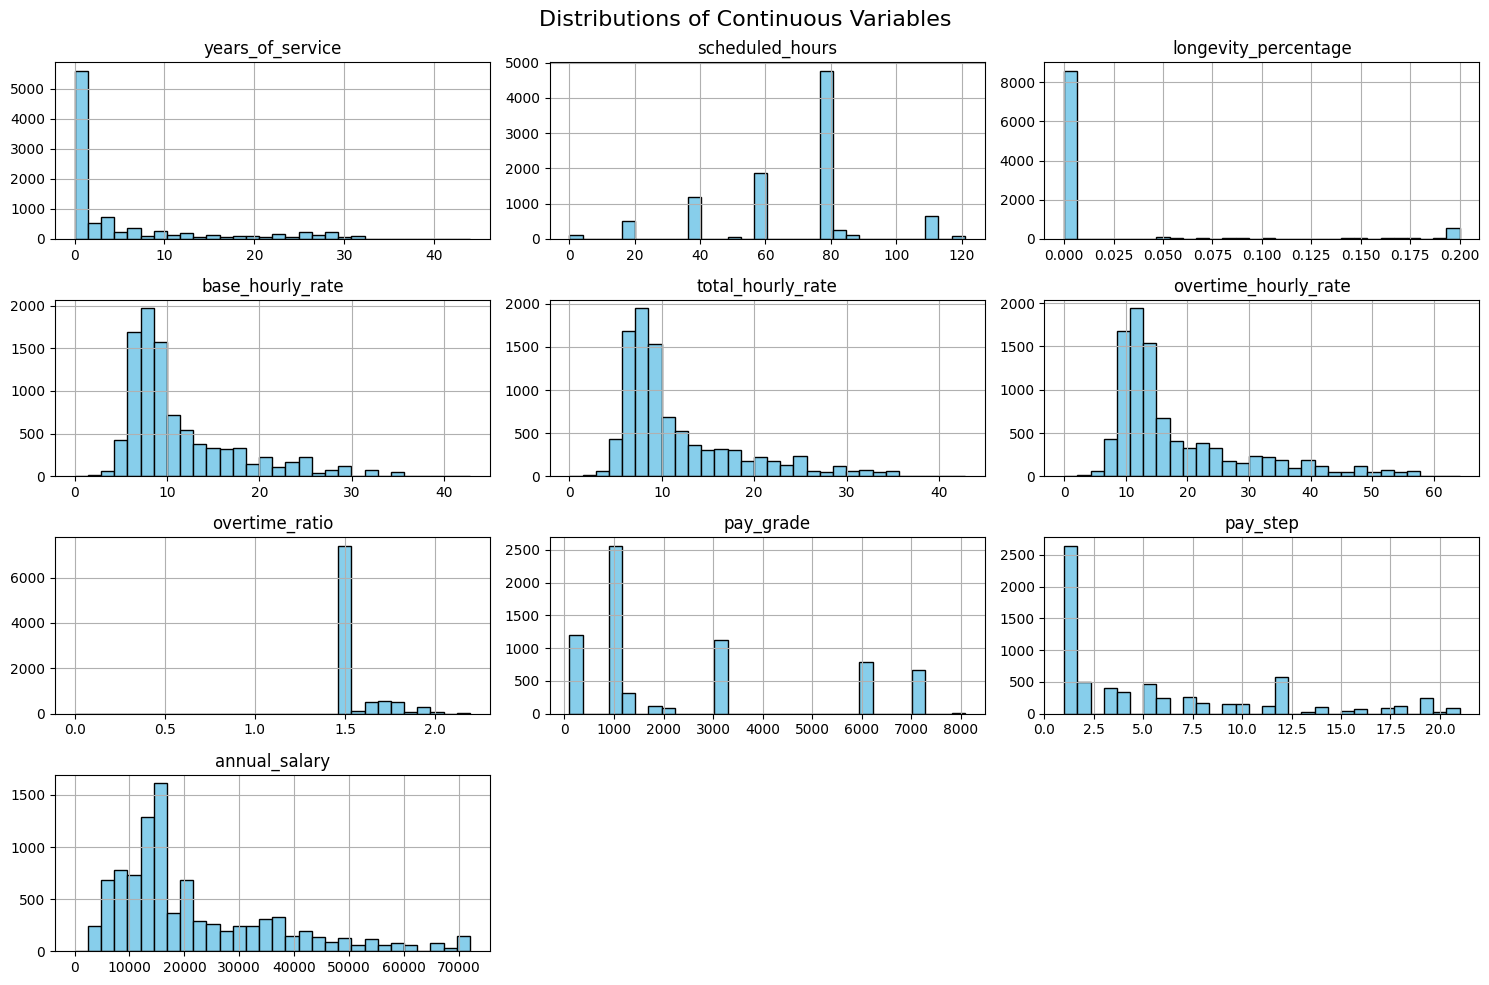

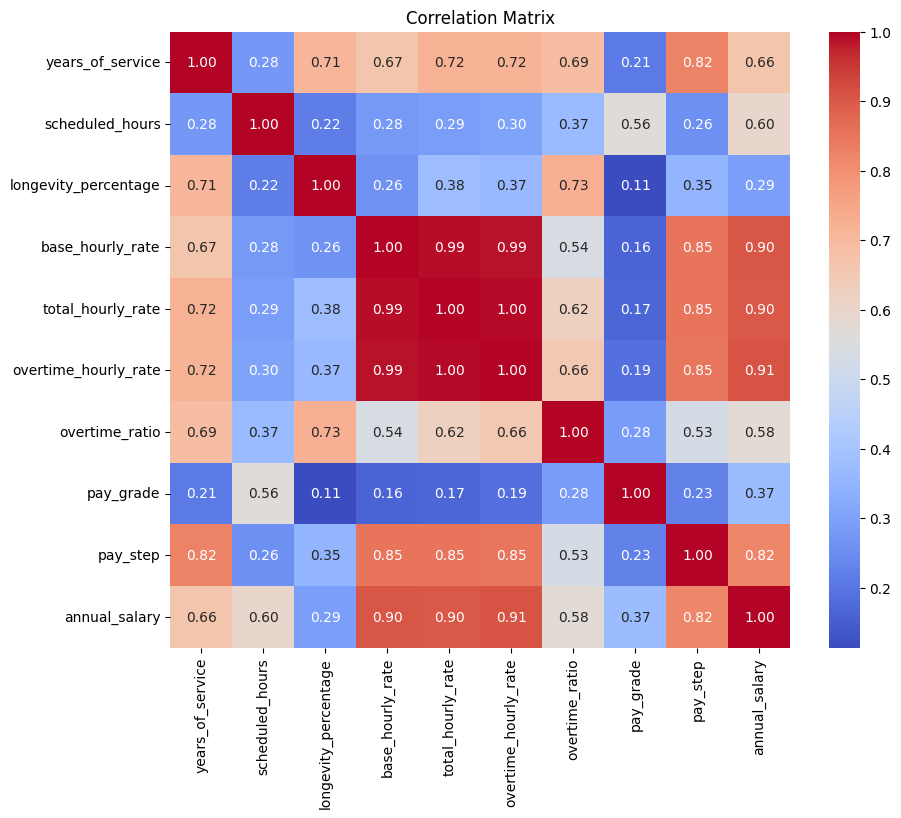

In [530]:
# Only keep continuous variables
numeric_df = merged_df_3[["years_of_service",
    "scheduled_hours",
    "longevity_percentage",
    "base_hourly_rate",
    "total_hourly_rate",
    "overtime_hourly_rate",
    "overtime_ratio",
    "pay_grade",
    "pay_step",
    "annual_salary"
]]
numeric_df.hist(bins=30, figsize=(15, 10), color='skyblue', edgecolor='black')
plt.suptitle("Distributions of Continuous Variables", fontsize=16)
plt.tight_layout()
plt.show()

corr = numeric_df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()




/var/folders/70/bv9d2gzn4373dn9w5fts5_f40000gp/T/ipykernel_7307/1864083512.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df_3['log_salary'] = np.log1p(merged_df_3['annual_salary'])


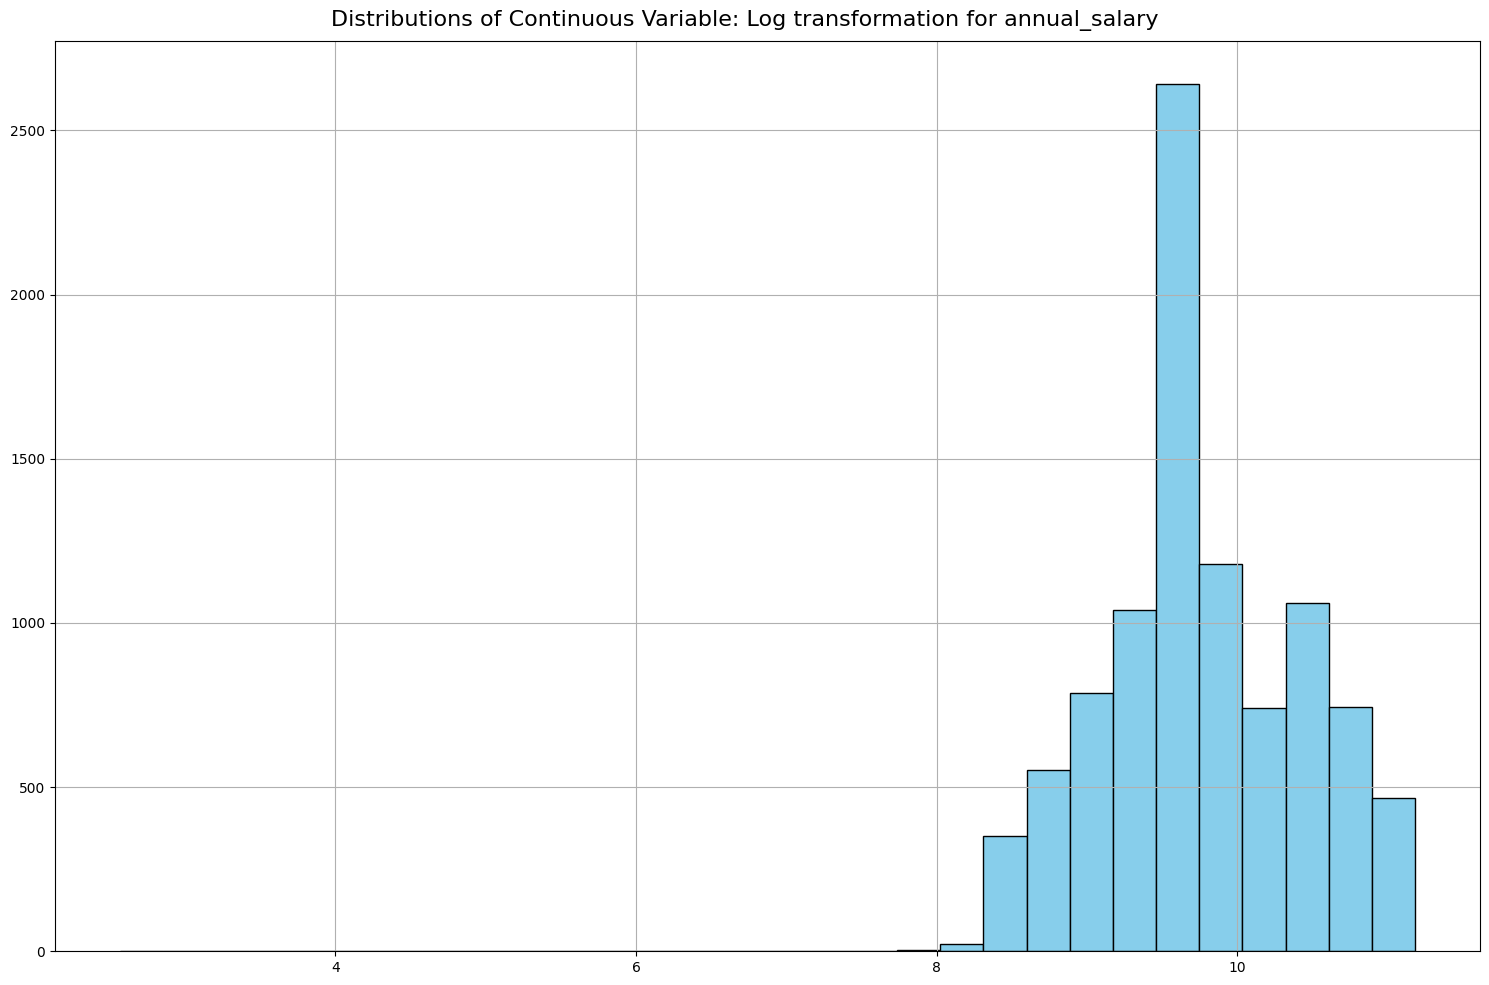

In [531]:
merged_df_3['log_salary'] = np.log1p(merged_df_3['annual_salary'])

merged_df_3['log_salary'].hist(bins=30, figsize=(15, 10), color='skyblue', edgecolor='black')
plt.suptitle("Distributions of Continuous Variable: Log transformation for annual_salary", fontsize=16)
plt.tight_layout()
plt.show()



<Figure size 300x300 with 0 Axes>

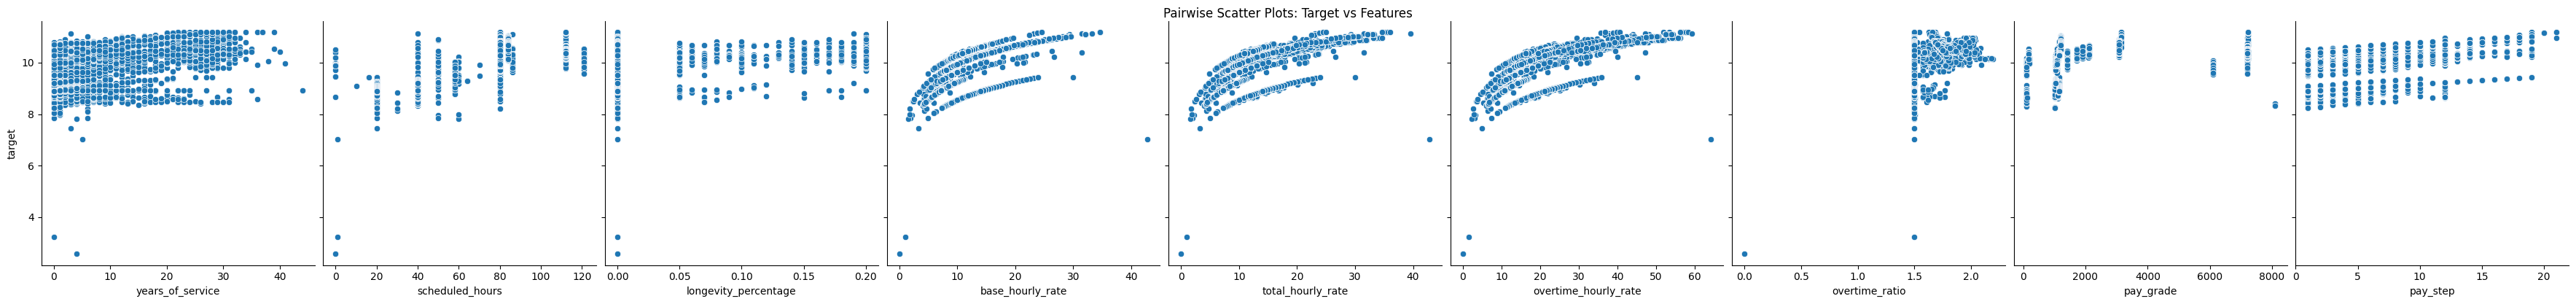

In [532]:
# Assuming X_train_dropped is your feature DataFrame and y_train is your target Series
features = ["years_of_service",
    "scheduled_hours",
    "longevity_percentage",
    "base_hourly_rate",
    "total_hourly_rate",
    "overtime_hourly_rate",
    "overtime_ratio",
    "pay_grade",
    "pay_step"]

# Combine target and selected features into one DataFrame for plotting
plot_df = pd.concat([merged_df_3[features], merged_df_3['log_salary'].rename('target')], axis=1)

# Create scatter plots
plt.figure(figsize=(3, 3), dpi=100, facecolor='w', edgecolor='k')
sns.pairplot(plot_df, x_vars=features, y_vars='target', height=4, aspect=1, kind='scatter')
plt.suptitle('Pairwise Scatter Plots: Target vs Features', y=1.02)
plt.show()

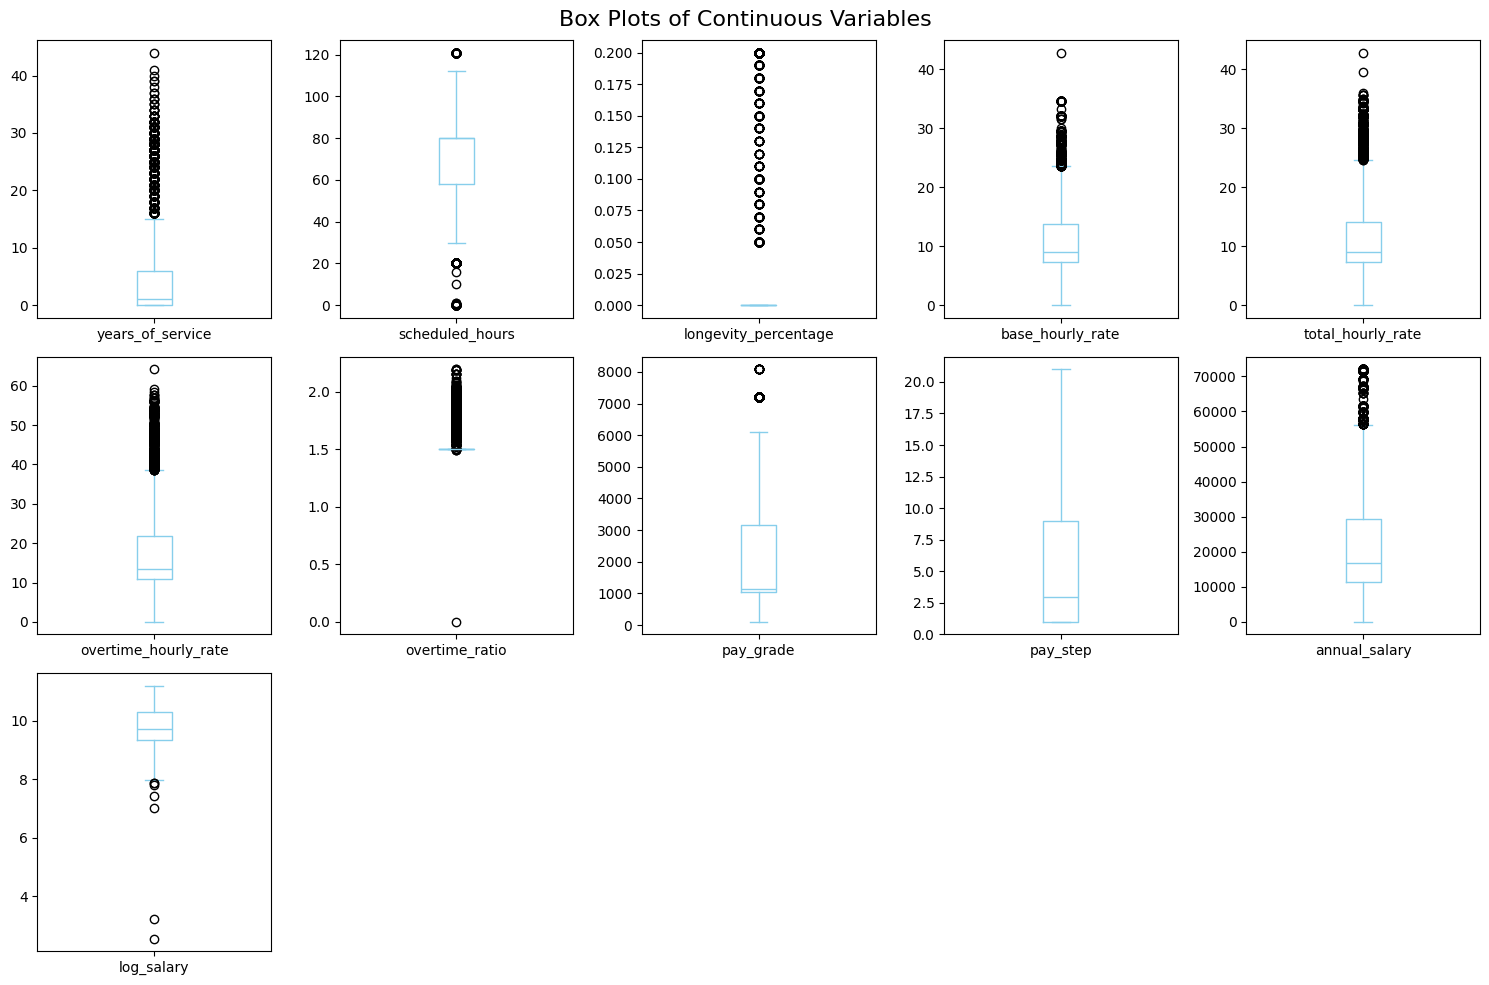

In [533]:
numeric_df = merged_df_3[["years_of_service",
    "scheduled_hours",
    "longevity_percentage",
    "base_hourly_rate",
    "total_hourly_rate",
    "overtime_hourly_rate",
    "overtime_ratio",
    "pay_grade",
    "pay_step",
    "annual_salary",
    "log_salary"
]]

numeric_df.plot(kind='box', figsize=(15, 10), color='skyblue',subplots=True, layout=(3, 5), sharex=False, sharey=False)
plt.suptitle("Box Plots of Continuous Variables", fontsize=16)
plt.tight_layout()
plt.show()

In [534]:
print(merged_df_3.info())

<class 'pandas.core.frame.DataFrame'>
Index: 9593 entries, 3 to 20553
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   pay_grade             6886 non-null   float64
 1   pay_step              6886 non-null   float64
 2   years_of_service      9593 non-null   int64  
 3   scheduled_hours       9593 non-null   float64
 4   longevity_percentage  9593 non-null   float64
 5   base_hourly_rate      9593 non-null   float64
 6   total_hourly_rate     9593 non-null   float64
 7   overtime_hourly_rate  9593 non-null   float64
 8   annual_salary         9593 non-null   float64
 9   job_title             9593 non-null   object 
 10  department_name       9593 non-null   object 
 11  overtime_ratio        9593 non-null   float64
 12  log_salary            9593 non-null   float64
dtypes: float64(10), int64(1), object(2)
memory usage: 1.0+ MB
None


In [545]:
print(merged_df_3.head(5))
print(np.expm1(10.529751))

    pay_grade  pay_step  years_of_service  scheduled_hours  \
3      2116.0      12.0                28             80.0   
4       100.0       1.0                36             40.0   
5      7201.0       9.0                11            121.0   
8      3160.0      12.0                29             80.0   
16     3140.0      19.0                26             80.0   

    longevity_percentage  base_hourly_rate  total_hourly_rate  \
3                   0.20             17.99              21.58   
4                   0.00              5.15               5.15   
5                   0.05              6.90               8.03   
8                   0.20             27.65              33.18   
16                  0.00             29.60              29.60   

    overtime_hourly_rate  annual_salary              job_title  \
3                  34.97       37411.14         Police Captain   
4                   7.72        5356.00  School Crossing Guard   
5                  13.65       20100.0

Null values present in pay_grade and pay_step columns,decided to impute these values after splitting to Train and Test set

In [ ]:
#Define features and target
X = merged_df_3.drop(columns=['annual_salary', 'log_salary'])
y = merged_df_3['log_salary']

print("X columns:",X.columns)



#Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [ ]:
from sklearn.impute import KNNImputer

knn_imputer = KNNImputer(n_neighbors=5)
X_train[['pay_grade', 'pay_step']] = knn_imputer.fit_transform(X_train[['pay_grade', 'pay_step']])
X_test[['pay_grade', 'pay_step']] = knn_imputer.transform(X_test[['pay_grade', 'pay_step']])

In [ ]:
# Only keep continuous variables
numeric_df = X_train[["years_of_service",
    "scheduled_hours",
    "longevity_percentage",
    "base_hourly_rate",
    "total_hourly_rate",
    "overtime_hourly_rate",
    "overtime_ratio",
    "pay_grade",
    "pay_step",
]]
numeric_df.hist(bins=30, figsize=(15, 10), color='skyblue', edgecolor='black')
plt.suptitle("Distributions of Continuous Variables- Train set", fontsize=16)
plt.tight_layout()
plt.show()

corr = numeric_df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()



# Only keep continuous variables
numeric_df = X_test[["years_of_service",
    "scheduled_hours",
    "longevity_percentage",
    "base_hourly_rate",
    "total_hourly_rate",
    "overtime_hourly_rate",
    "overtime_ratio",
    "pay_grade",
    "pay_step",
]]
numeric_df.hist(bins=30, figsize=(15, 10), color='skyblue', edgecolor='black')
plt.suptitle("Distributions of Continuous Variables - Test Set", fontsize=16)
plt.tight_layout()
plt.show()

corr = numeric_df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()



#### One hot Encoding For job_title

In [ ]:
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

# Step 1: Initialize encoder with correct settings
encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')

# Step 2: Fit on training set ONLY
encoder.fit(X_train[['job_title']])

# Step 3: Transform train and test
train_encoded = encoder.transform(X_train[['job_title']])
test_encoded = encoder.transform(X_test[['job_title']])

# Step 4: Convert to DataFrames with matching indices and correct column names
encoded_train_df = pd.DataFrame(train_encoded, 
                                columns=encoder.get_feature_names_out(['job_title']),
                                index=X_train.index)

encoded_test_df = pd.DataFrame(test_encoded, 
                               columns=encoder.get_feature_names_out(['job_title']),
                               index=X_test.index)

# Step 5: Drop the original 'job_title' column and concatenate the encoded DataFrames
X_train_encode = pd.concat([X_train.drop('job_title', axis=1), encoded_train_df], axis=1)
X_test_encode = pd.concat([X_test.drop('job_title', axis=1), encoded_test_df], axis=1)

X_train_encode = X_train_encode.drop(columns=['department_name'])
X_test_encode = X_test_encode.drop(columns=['department_name'])
print("X_train_encode columns:", X_train_encode.head(1))
print("X_test_encode columns:", y_train.head(1))


In [ ]:
# # Step 2: Fit on training set ONLY
# encoder.fit(X_train_encode_1[['department_name']])

# # Step 3: Transform train and test
# train_encoded = encoder.transform(X_train_encode_1[['department_name']])
# test_encoded = encoder.transform(X_test_encode_1[['department_name']])

# # Step 4: Convert to DataFrames from the encoded arrays
# encoded_train_df = pd.DataFrame(train_encoded, 
#                                 columns=encoder.get_feature_names_out(['department_name']),
#                                 index=X_train_encode_1.index)

# encoded_test_df = pd.DataFrame(test_encoded, 
#                                columns=encoder.get_feature_names_out(['department_name']),
#                                index=X_test_encode_1.index)

# # Step 5: Drop the original 'department_name' column and concatenate the encoded DataFrames
# X_train_encode_final = pd.concat([X_train_encode_1.drop('department_name', axis=1), encoded_train_df], axis=1)
# X_test_encode_final = pd.concat([X_test_encode_1.drop('department_name', axis=1), encoded_test_df], axis=1)

# print(X_train_encode_final.shape, X_test_encode_final.shape)


In [ ]:
# Checking null values in Train and test set
print(X_train_encode.info())
print(X_test_encode.info())


#### Checking Train and Test Distribution

In [ ]:
import pandas as pd

def compare_distributions(train_df, test_df, features):
    summary = []
    for f in features:
        train_stats = train_df[f].describe()
        test_stats = test_df[f].describe()
        summary.append({
            'feature': f,
            'train_mean': train_stats['mean'],
            'test_mean': test_stats['mean'],
            'train_std': train_stats['std'],
            'test_std': test_stats['std'],
            'mean_diff': abs(train_stats['mean'] - test_stats['mean']),
            'std_diff': abs(train_stats['std'] - test_stats['std']),
        })
    return pd.DataFrame(summary)


features_to_check = ['pay_grade', 'pay_step', 'years_of_service', 'scheduled_hours',
       'longevity_percentage', 'base_hourly_rate', 'total_hourly_rate',
       'overtime_hourly_rate', 'overtime_ratio',
       'job_title_Displaced Disaster Worker', 'job_title_EMT Paramedic',
       'job_title_Exception Job Code', 'job_title_Fire Captain',
       'job_title_Firefighter', 'job_title_Laborer',
       'job_title_Library Page (20 hrs)', 'job_title_Library Technician I',
       'job_title_Library Technician I (10 hrs)',
       'job_title_Maintenance Worker I', 'job_title_Maintenance Worker II',
       'job_title_Police Captain', 'job_title_Police Lieutenant',
       'job_title_Police Officer', 'job_title_Police Sergeant',
       'job_title_School Crossing Guard',
       'job_title_Senior Clerical Specialist']
compare_distributions(X_train_encode, X_test_encode, features_to_check)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

for f in features_to_check:
    plt.figure(figsize=(8,4))
    sns.kdeplot(X_train_encode[f], label='Train', fill=True)
    sns.kdeplot(X_test_encode[f], label='Test', fill=True)
    plt.title(f'Distribution of {f} in Train vs Test')
    plt.legend()
    plt.show()

In [ ]:
from scipy.stats import ks_2samp

for f in features_to_check:
    stat, p = ks_2samp(X_train_encode[f], X_test_encode[f])
    print(f'{f}: KS stat={stat:.4f}, p-value={p:.4f}')


In [ ]:
plt.figure(figsize=(8,4))
sns.kdeplot(y_train, label='Train target', fill=True)
sns.kdeplot(y_test, label='Test target', fill=True)
plt.title("Target variable distribution (log salary)")
plt.legend()
plt.show()

#### Variation Inflation Factor

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant



X = add_constant(X_train_encode)

vif = pd.DataFrame()
vif["features"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(vif)

##### Dropping 'base_hourly_rate','overtime_hourly_rate','years_of_service'

In [ ]:
X_train_encode_final = X_train_encode.drop(columns=['base_hourly_rate','overtime_hourly_rate','years_of_service'])
X_test_encode_final = X_test_encode.drop(columns=['base_hourly_rate','overtime_hourly_rate','years_of_service'])
print(X_train_encode_final.shape, X_test_encode_final.shape)
print(X_train_encode_final.columns)

#### Checking Variation Inflation Factor after removing 'base_hourly_rate','overtime_hourly_rate','years_of_service'

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant



X = add_constant(X_train_encode_final)

vif = pd.DataFrame()
vif["features"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(vif)

In [ ]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_encode_final)
X_test_scaled = scaler.transform(X_test_encode_final)
print(X_train_scaled)

#### Fitting a baseline Regression Model

In [ ]:
# Fit the model
model = LinearRegression()
model.fit(X_train_scaled, y_train)
# Make predictions
y_pred = model.predict(X_test_scaled)
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")
# Print coefficients
coefficients = pd.DataFrame(model.coef_, X_train_encode_final.columns, columns=['Coefficient'])
print("Coefficients:")
print(coefficients.sort_values(by='Coefficient', ascending=False))
# Plot actual vs predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Log Salary')
plt.ylabel('Predicted Log Salary')
plt.title('Actual vs Predicted Log Salary')
plt.show()

The baseline regression model shows strong predictive performance, with a low Mean Squared Error (0.0135) and a high R-squared value of 0.969, indicating that the model explains about 97% of the variance in the target variable. Among the features, total_hourly_rate has the largest positive impact on the outcome, while scheduled_hours also contributes positively but to a lesser extent. Some job titles have notable effects, for example, Firefighter and Displaced Disaster Worker are associated with positive coefficients, while Library Technician I (10 hrs) and School Crossing Guard have negative associations. Overall, the coefficients reflect how pay grades, hours worked, job roles, and other factors influence the predicted value.

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Create pipeline with scaling and ridge regression
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', Ridge())
])

# Hyperparameter tuning for alpha (regularization strength)
param_grid = {'ridge__alpha': [0.01, 0.1, 1, 10, 100]}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='r2')
grid_search.fit(X_train_encode_final, y_train)

print("Best alpha:", grid_search.best_params_)
print("Best CV R2:", grid_search.best_score_)

# Evaluate on test set
best_model = grid_search.best_estimator_
r2_test = best_model.score(X_test_encode_final, y_test)
print("Test R2:", r2_test)


In [ ]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Pipeline: scaling + Lasso regression
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lasso', Lasso(max_iter=10000))
])

# Grid of alpha values to try
param_grid = {'lasso__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='r2')
grid_search.fit(X_train_encode_final, y_train)

print("Best alpha:", grid_search.best_params_)
print("Best CV R2:", grid_search.best_score_)

best_model = grid_search.best_estimator_
r2_test = best_model.score(X_test_encode_final, y_test)
print("Test R2:", r2_test)

# Get feature coefficients
coefs = best_model.named_steps['lasso'].coef_
feature_importance = pd.Series(coefs, index=X_train_encode_final.columns)

# Get std deviation of target
y_std = y_train.std()

# Get std dev of each feature (from original X, not scaled!)
X_std = X_train_encode_final.std()
X_std = X_std.replace(0, np.nan)  # prevent divide-by-zero


unstandardized_coef = coefs * y_std / X_std
unstandardized_coef = unstandardized_coef.replace([np.inf, -np.inf], np.nan) 

# Put in DataFrame for easier reading
coef_df = pd.DataFrame({
    'feature': X_train_encode_final.columns,
    'standardized_coef': coefs,
    'unstandardized_coef': unstandardized_coef
})
print("Top features (by unstandardized impact on salary):")
print(coef_df.sort_values(by='unstandardized_coef', ascending=False).head(10))
print("Bottom features:")
print(coef_df.sort_values(by='unstandardized_coef', ascending=True).head(10))


In [ ]:
import matplotlib.pyplot as plt

top = coef_df.sort_values(by='unstandardized_coef', ascending=False).head(10)
bottom = coef_df.sort_values(by='unstandardized_coef', ascending=True).head(10)

plt.figure(figsize=(15, 10))
pd.concat([top, bottom]).plot(kind='barh', x='feature', y='unstandardized_coef', color='teal', legend=False)
plt.title('Top Positive & Negative Lasso Feature Effects on Salary ($)')
plt.xlabel('Effect on Annual Salary')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import xgboost as xgb
from sklearn.metrics import r2_score
import shap

# 1. Train XGBoost model
xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_train_encode_final, y_train)

# 2. Evaluate model
y_pred = xgb_model.predict(X_test_encode_final)
print(f"Test R2: {r2_score(y_test, y_pred):.4f}")

# 3. Initialize SHAP explainer
explainer = shap.Explainer(xgb_model)
shap_values = explainer(X_test_encode_final)

# 4. SHAP summary plot (global importance)
shap.summary_plot(shap_values, X_test_encode_final)

# 5. SHAP waterfall plot for a single prediction
shap.plots.waterfall(shap_values[0])


In [ ]:
import pickle
xgb_model.get_booster().feature_names


with open('/Users/suvedharam/payroll-prediction/model/xgb_model.pkl', 'wb') as f:
    pickle.dump(xgb_model, f)


In [ ]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(best_model, X_train_encode_final, y_train, cv=5, scoring='r2')
print(f"CV R2 scores: {cv_scores}")
print(f"Mean CV R2: {cv_scores.mean():.4f}, Std: {cv_scores.std():.4f}")


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

# Train the model
print(X_train_encode_final.shape, X_train_encode_final.shape)
print(X_train_encode_final.columns) 
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_encode_final, y_train)

# Evaluate on test set
y_pred_rf = rf_model.predict(X_test_encode_final)

from sklearn.metrics import r2_score, mean_squared_error
print("Test R2:", r2_score(y_test, y_pred_rf))
mse = mean_squared_error(y_test, y_pred_rf)
print("RMSE:", np.sqrt(mse))


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Get feature importances from RF
importances = rf_model.feature_importances_
feature_names = X_train_encode_final.columns
print("Feature importances:", importances.shape)
print("Feature names:", feature_names.shape)
feat_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
feat_importance_df = feat_importance_df.sort_values(by='importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(feat_importance_df['feature'][:15][::-1], feat_importance_df['importance'][:15][::-1])
plt.xlabel("Feature Importance")
plt.title("Top 15 Important Features (Random Forest)")
plt.tight_layout()
plt.show()


In [ ]:
# 3. Initialize SHAP explainer
explainer = shap.Explainer(rf_model)
shap_values = explainer(X_test_encode_final)

# 4. SHAP summary plot (global importance)
shap.summary_plot(shap_values, X_test_encode_final)

# 5. SHAP waterfall plot for a single prediction
shap.plots.waterfall(shap_values[0])


In [ ]:
import pickle
xgb_model.get_booster().feature_names


with open('/Users/suvedharam/payroll-prediction/model/rf_model.pkl', 'wb') as f:
    pickle.dump(rf_model, f)

In [544]:
# model = your trained Random Forest model
y_pred_log = rf_model.predict(X_train_encode_final)

# Residuals in log space
residuals_log = y_train - y_pred_log

# Standard deviation of residuals
residual_std_log = np.std(residuals_log)
print(f"Residual Std Dev (log space): {residual_std_log:.4f}")


Residual Std Dev (log space): 0.0343


In [547]:
# Save residual_std_log
with open('/Users/suvedharam/payroll-prediction/model/residual_std_log.pkl', 'wb') as f:
    pickle.dump(residual_std_log, f)